<a href="https://colab.research.google.com/github/SubashiniB181203/Time-Series-Analysis-Lab/blob/main/221501145_TSA_exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***3. Check stationary of a time series data***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [2]:
# Load CSV file
file_path = "/content/drive/MyDrive/time_series_data.csv"  # Update with your file path
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [3]:
# Assume time series column is the second column
ts = df.iloc[:, 0]

In [4]:
def test_stationarity(timeseries, description="Original Data"):
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    adf_test = adfuller(timeseries.dropna(), autolag='AIC')
    kpss_test = kpss(timeseries.dropna(), regression='c', nlags="auto")

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(timeseries, label=description, color="blue", alpha=0.5)
    ax.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
    ax.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dotted")

    adf_text = f"ADF Test: Statistic={adf_test[0]:.4f}, p-value={adf_test[1]:.4f}"
    kpss_text = f"KPSS Test: Statistic={kpss_test[0]:.4f}, p-value={kpss_test[1]:.4f}"

    ax.text(0.02, 0.95, adf_text, transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    ax.text(0.02, 0.90, kpss_text, transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    ax.set_title(f"Stationarity Test - {description}")
    ax.legend()
    plt.grid()
    plt.show()

    print(f"{description}:")
    print(f"ADF Test: Test Statistic = {adf_test[0]:.4f}, p-value = {adf_test[1]:.4f} (Stationary if p<0.05)")
    print("=> Stationary" if adf_test[1] < 0.05 else "=> Not Stationary") # Changed line
    print(f"KPSS Test: Test Statistic = {kpss_test[0]:.4f}, p-value = {kpss_test[1]:.4f} (Stationary if p>0.05)")
    print("=> Stationary" if kpss_test[1] > 0.05 else "=> Not Stationary") # Changed line

    return adf_test[1] < 0.05 and kpss_test[1] > 0.05

<ipython-input-4-eef29ba1093a>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(timeseries.dropna(), regression='c', nlags="auto")


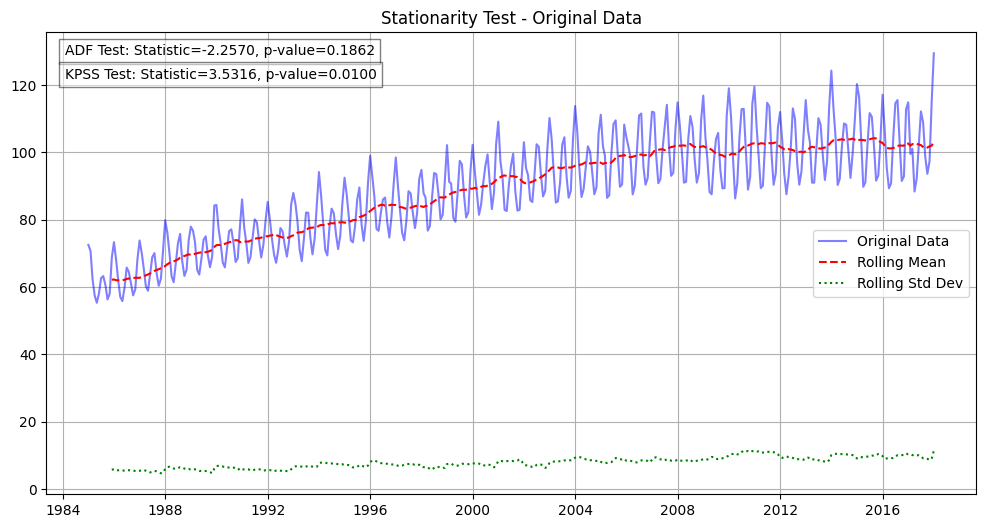

Original Data:
ADF Test: Test Statistic = -2.2570, p-value = 0.1862 (Stationary if p<0.05)
=> Not Stationary
KPSS Test: Test Statistic = 3.5316, p-value = 0.0100 (Stationary if p>0.05)
=> Not Stationary
Applying transformations to achieve stationarity...


<ipython-input-4-eef29ba1093a>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(timeseries.dropna(), regression='c', nlags="auto")


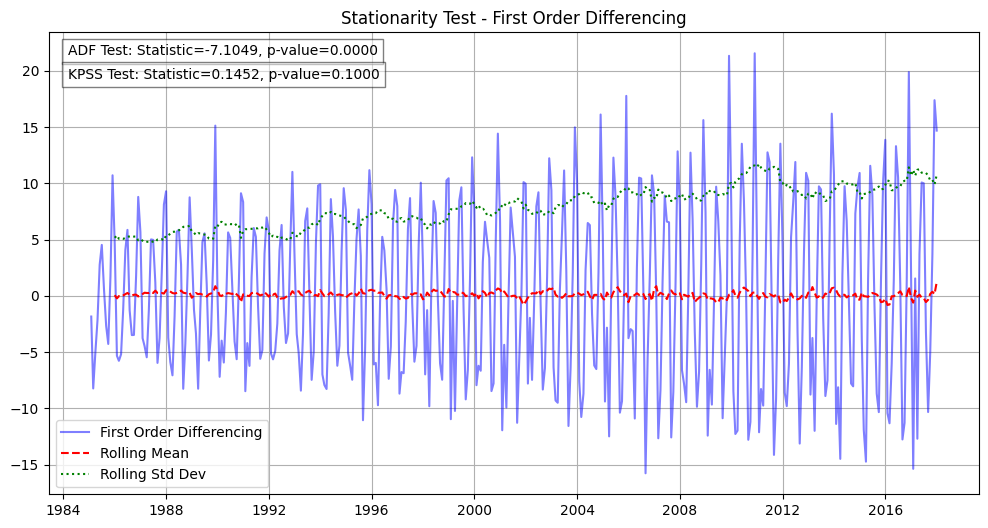

First Order Differencing:
ADF Test: Test Statistic = -7.1049, p-value = 0.0000 (Stationary if p<0.05)
=> Stationary
KPSS Test: Test Statistic = 0.1452, p-value = 0.1000 (Stationary if p>0.05)
=> Stationary


In [5]:
# Check stationarity of original data
if test_stationarity(ts):
    print("The time series is already stationary.")
else:
    # Apply transformations
    print("Applying transformations to achieve stationarity...")

    # 1. Differencing
    ts_diff = ts.diff().dropna()
    if test_stationarity(ts_diff, "First Order Differencing"):
        ts = ts_diff
    else:
        # 2. Log Transformation
        ts_log = np.log(ts).dropna()
        if test_stationarity(ts_log, "Log Transformation"):
            ts = ts_log
        else:
            # 3. Box-Cox Transformation
            ts_boxcox, _ = boxcox(ts.dropna())
            ts_boxcox = pd.Series(ts_boxcox, index=ts.index.dropna())
            if test_stationarity(ts_boxcox, "Box-Cox Transformation"):
                ts = ts_boxcox
            else:
                # 4. Seasonal Decomposition
                decomposed = seasonal_decompose(ts, model="additive", period=12)
                ts_adjusted = ts - decomposed.trend
                ts_adjusted.dropna(inplace=True)
                if test_stationarity(ts_adjusted, "Seasonal Decomposition"):
                    ts = ts_adjusted
                else:
                    print("Warning: Time series could not be fully transformed into stationary form.")